# benchmark IBD calling accuracy

In [1]:
from plot_utility import calc_FP_all
import numpy as np


# wgs

In [ ]:
import matplotlib.pyplot as plt

bins = [(5,6),(6,7), (7,8), (8,10), (10,15), (15, np.inf)]
covs = ['cov5', 'cov2', 'cov1', 'cov3over4', 'cov1over2', 'cov1over4', 'cov1over10']
cov2str = {'cov5':'5x', 'cov2':'2x', 'cov1':'1x', 'cov3over4':'0.75x', 'cov1over2':'0.5x', 'cov1over4':'0.25x', 'cov1over10':'0.1x'}


for i, bin in enumerate(bins):
    print(f'doing bin: {bin}')
    fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(24, 12), tight_layout=True)
    for index, cov in enumerate(covs):
        print(f'doing coverage {cov2str[cov]}')
        i, j = index//4, index%4
        density, fraction_covered, oppoHomoRates = calc_FP_all(f'./callIBD/wgs/{cov}', bin[0], bin[1], threshold=0.5)
        axs[i,j].scatter(fraction_covered, oppoHomoRates, color='blue', alpha=0.3, label='ancIBD')

        density, fraction_covered, oppoHomoRates = calc_FP_all(f'./callIBD/wgs/{cov}', bin[0], bin[1], mode='IBIS_1240k', threshold=0.5)
        axs[i,j].scatter(fraction_covered, oppoHomoRates, color='orange', alpha=0.3, label='IBIS_1240k')

        axs[i,j].set_title(f'simulated coverage: {cov2str[cov]}', fontsize=18)
        if i == j == 0:
            axs[i,j].legend(loc='upper right', fontsize='xx-large')
    axs[1,3].set_visible(False)
    
    fig.text(0.5, 1.01, f'Length Bin: {bin[0]}-{bin[1]}cM', ha='center', va='center', fontsize=30)
    fig.text(0.5, -0.01, 'PPV', ha='center', va='center', fontsize=30)
    fig.text(-0.01, 0.5, 'Rate of Opposing Homozygotes', ha='center', va='center', rotation='vertical', fontsize=30)
    plt.savefig(f'./wgs/snpDensity_{bin[0]}-{bin[1]}cM.png', dpi=300, bbox_inches = "tight")

# 1240k

In [ ]:
import matplotlib.pyplot as plt

bins = [(5,6),(6,7),(7,8), (8,10), (10,15), (15, np.inf)]
covs = ['cov2', 'cov1', 'cov3over4', 'cov1over2']
cov2str = {'cov5':'5x', 'cov2':'2x', 'cov1':'1x', 'cov3over4':'0.75x', 'cov1over2':'0.5x'}


for i, bin in enumerate(bins):
    print(f'doing bin: {bin}')
    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(24, 12), tight_layout=True)
    for index, cov in enumerate(covs):
        print(f'doing coverage {cov2str[cov]}')
        i, j = index//2, index%2
        density, fraction_covered, oppoHomo = calc_FP_all(f'./callIBD/1240k/{cov}', bin[0], bin[1], threshold=0.5)
        axs[i,j].scatter(fraction_covered, oppoHomo, color='blue', alpha=0.3, label='ancIBD')
        avgNumFP_ancIBD = np.sum(np.array(fraction_covered) < 0.1)/(50*6)

        density, fraction_covered, oppoHomo = calc_FP_all(f'./callIBD/1240k/{cov}', bin[0], bin[1], mode='IBIS_1240k', threshold=0.5)
        axs[i,j].scatter(fraction_covered, oppoHomo, color='orange', alpha=0.3, label='IBIS_1240k')
        avgNumFP_ibis = np.sum(np.array(fraction_covered) < 0.1)/(50*6)

        axs[i,j].set_title(f'simulated coverage: {cov2str[cov]}', fontsize=18)
        if i == j == 0:
            axs[i,j].legend(loc='upper right', fontsize='xx-large')

    
    fig.text(0.5, 1.01, f'Length Bin: {bin[0]}-{bin[1]}cM', ha='center', va='center', fontsize=30)
    fig.text(0.5, -0.01, 'PPV', ha='center', va='center', fontsize=30)
    fig.text(-0.01, 0.5, 'Rate of Opposing Homozygotes', ha='center', va='center', rotation='vertical', fontsize=30)
    plt.savefig(f'./1240k/snpDensity_{bin[0]}-{bin[1]}cM.png', dpi=300, bbox_inches = "tight")

# side by side plot

# Test of allele freq

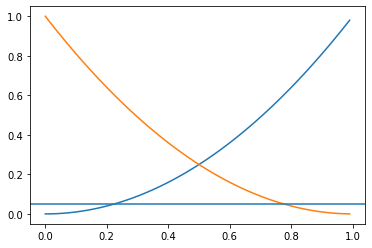

In [3]:
import numpy as np
import matplotlib.pyplot as plt

allelfreq = np.arange(0, 1, 0.01)
plt.plot(allelfreq, allelfreq**2)
plt.plot(allelfreq, (1-allelfreq)*(1-allelfreq))
plt.axhline(y=0.05)

In [3]:
from plot_utility import get_individual_idx, calc_FP_all
import numpy as np
from collections import defaultdict
import time
import h5py
import itertools
from tqdm import tqdm


path2HDF5 = '/mnt/archgen/users/yilei/IBDsim/groundtruth_IBD_glimpse_transversion/MAC0/hdf5'
iids = ['I2105', 'I3950', 'I5279', 'I5273']

t1 = time.time()
bp_vec = {}
homo_index = defaultdict(lambda:{})
oppoHomo_index = defaultdict(lambda:{})
for ch in tqdm(np.arange(1,23)):
    f = h5py.File(f'{path2HDF5}/ch{ch}.h5', 'r')
    filterByAF = np.where(np.array(f['variants/RAF'][:,0])>0.1)[0]
    bp_vec[ch] = np.array(f['variants/POS'])[filterByAF]
    print(f'extracting bp position done', flush=True)
    for id1, id2 in itertools.combinations(iids, 2):
        index1, index2 = get_individual_idx(f, id1), get_individual_idx(f, id2)
        print(f'index1: {index1}, index2: {index2}', flush=True)
        gt1 = f['calldata/GT'][:, index1, :]
        gt2 = f['calldata/GT'][:, index2, :]
        gt1 = np.sum(gt1[filterByAF], axis=1)
        gt2 = np.sum(gt2[filterByAF], axis=1)
        #gt1 = np.sum(f['calldata/GT'][filterByAF, index1, :], axis=1)
        #gt2 = np.sum(f['calldata/GT'][filterByAF, index2, :], axis=1)
        print('extracting gt done', flush=True)
        assert(len(gt1) == len(gt2))
        assert(len(gt1) == len(bp_vec[ch]))
        print(f'sanity check done')
        homo_index[(min(id1, id2), max(id1, id2))][ch] = np.where(np.logical_and(np.logical_or(gt1==0, gt1==2), np.logical_or(gt2==0, gt2==2)))[0]
        oppoHomo_index[(min(id1, id2), max(id1, id2))][ch] = np.where(np.logical_or(np.logical_and(gt1==0, gt2==2), np.logical_and(gt1==2, gt2==0)))[0]
        print(f'common homozygote position done', flush=True)
    f.close()

print(f'pre-computation finished, takes {time.time()-t1}s', flush=True)


  0%|          | 0/22 [00:00<?, ?it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


  5%|▍         | 1/22 [00:00<00:04,  4.64it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


  9%|▉         | 2/22 [00:00<00:06,  3.25it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 14%|█▎        | 3/22 [00:01<00:06,  2.97it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 18%|█▊        | 4/22 [00:01<00:06,  2.93it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 23%|██▎       | 5/22 [00:01<00:05,  2.93it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 27%|██▋       | 6/22 [00:02<00:05,  2.96it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 32%|███▏      | 7/22 [00:02<00:05,  3.00it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 36%|███▋      | 8/22 [00:02<00:04,  3.01it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 41%|████      | 9/22 [00:02<00:04,  3.12it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 45%|████▌     | 10/22 [00:03<00:03,  3.18it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 50%|█████     | 11/22 [00:03<00:03,  3.21it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 55%|█████▍    | 12/22 [00:03<00:03,  3.26it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 59%|█████▉    | 13/22 [00:03<00:02,  3.34it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 64%|██████▎   | 14/22 [00:04<00:02,  3.44it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 68%|██████▊   | 15/22 [00:04<00:01,  3.55it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 73%|███████▎  | 16/22 [00:04<00:01,  3.62it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 77%|███████▋  | 17/22 [00:04<00:01,  3.70it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 82%|████████▏ | 18/22 [00:04<00:01,  3.77it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 86%|████████▋ | 19/22 [00:04<00:00,  3.84it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 91%|█████████ | 20/22 [00:05<00:00,  3.89it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


 95%|█████████▌| 21/22 [00:05<00:00,  3.97it/s]

extracting bp position done
index1: 0, index2: 1
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 0, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 3
extracting gt done
sanity check done
common homozygote position done
index1: 1, index2: 2
extracting gt done
sanity check done
common homozygote position done
index1: 3, index2: 2
extracting gt done
sanity check done
common homozygote position done


100%|██████████| 22/22 [00:05<00:00,  4.04it/s]

pre-computation finished, takes 5.447493076324463s
